<a href="https://colab.research.google.com/github/juancaalcaraz/RandomForest4-sensibilidad-farmacologicaad/blob/main/RadomForest4sensibilidadFarmacol%C3%B3gica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción de la sensibilidad de Fármacos en Cáncer Utilizando Bosques Aleatorios.
## Proyecto sobre la predicción de la sensibilidad de diferentes fármacos en base a datos genómicos.
Este notebook se enfoca en la implementación de un modelo de Machine Learning para la predicción de la sensibilidad de distintas drogas en células cancerosas.
El data set utilizado proviene del proyecto **Genomics of drugs Sensitivity in cancer (GDSC)**, que contiene información sobre la respuesta de células cancerígenas a varios tratamientos. Este dataset esta distribuido bajo licencia GPL 3 y puedes descargarlo directamente de este link [Kaggle GDSC](https://www.kaggle.com/datasets/samiraalipour/genomics-of-drug-sensitivity-in-cancer-gdsc). Para este proyecto, solo usamos el archivo GDSC_DATASET.csv, del cual encontrarás más detalles en el enlace proporcionado.
### Objetivos:
- Preprocesar los datos del GDSC.
- Entrenar un modelo de **Bosque Aletorio** y de **Árbol de desición** para comparar sus rendimientos para predecir la sensibilidad de drogas en cáncer.
- Evaluar el desempeño de ambos rendimientos.
- Encontrar un modelo que tenga un buen desempeño explicando la variable objetivo LN_IC50.
### Descripción del dataset:
El dataset **GDSC** contiene información sobre células cancerígenas y su respuesta a distintos compuestos farmacológicos.
Los datos incluyen características genómicas de las células cancerígenas, como la expresión génica, mutaciones, y otras variables moleculares.
La variable LN_IC50(Logaritmo natural de la concentración inhibitoria semi-máxima) representa la concentración de un fármaco que inhibe la viabilidad celular en un 50% medido mediante una escala logarítmica. Los valores más bajos indican una mayor sensibilidad al fármaco; Debido a esto, se usa como métrica para evaluar la eficacia de los fármacos anticancerígenos.   

### Introducción:
La predicción de la sensibilidad de fármacos en células cancerígenas es un área de gran interés en la investigación farmacológica, pues permite personalizar tratamientos y mejorar los resultados terapéuticos en pacientes con cáncer. En este contexto, los modelos de Machine Learning han demostrado ser herramientas poderosas para predecir cómo diferentes células cancerígenas responderán a diversos fármacos, basándose en datos genómicos y moleculares.

Este notebook se enfoca en el uso de Random Forest, un modelo de Machine Learning basado en árboles de decisión, para predecir la sensibilidad de varios fármacos en células cancerosas. A través del uso de datos proporcionados por el proyecto Genomics of Drug Sensitivity in Cancer (GDSC), se busca entrenar un modelo que sea capaz de estimar con precisión la sensibilidad a fármacos en función de características genómicas de las células. En particular, la variable objetivo de este proyecto es el LN_IC50, que indica la concentración de un fármaco necesaria para inhibir la viabilidad celular al 50%.

A lo largo de este proyecto, se compararán los resultados del modelo de Random Forest con los de otros enfoques, como el Árbol de Decisión, para determinar cuál proporciona un mejor desempeño en la predicción de la sensibilidad de los fármacos en cáncer. El objetivo final es identificar un modelo robusto y eficiente que pueda contribuir a la mejora de tratamientos farmacológicos dirigidos y personalizados para pacientes con cáncer.

### Importación de librerías necesarias.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

### Carga y Exploración de Datos.

In [ ]:
# Cargando el dataset.
data = pd.read_csv("GDSC_DATASET.csv")
# Mostrando las primeras 10 filas.
data.head(10)

,COSMIC_ID,CELL_LINE_NAME,TCGA_DESC,DRUG_ID,DRUG_NAME,LN_IC50,AUC,Z_SCORE,GDSC Tissue descriptor 1,GDSC Tissue descriptor 2,Cancer Type (matching TCGA label),Microsatellite instability Status (MSI),Screen Medium,Growth Properties,CNA,Gene Expression,Methylation,TARGET,TARGET_PATHWAY
0,683667,PFSK-1,MB,1003,Camptothecin,-1.463887,0.930220,0.433123,nervous_system,medulloblastoma,MB,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
1,684057,ES5,UNCLASSIFIED,1003,Camptothecin,-3.360586,0.791072,-0.599569,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
2,684059,ES7,UNCLASSIFIED,1003,Camptothecin,-5.044940,0.592660,-1.516647,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
3,684062,EW-11,UNCLASSIFIED,1003,Camptothecin,-3.741991,0.734047,-0.807232,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
4,684072,SK-ES-1,UNCLASSIFIED,1003,Camptothecin,-5.142961,0.582439,-1.570016,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Semi-Adherent,Y,Y,Y,TOP1,DNA replication
5,687448,COLO-829,SKCM,1003,Camptothecin,-1.235034,0.867348,0.557727,skin,melanoma,SKCM,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
6,687452,5637,BLCA,1003,Camptothecin,-2.632632,0.834067,-0.203221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TOP1,DNA replication
7,687455,RT4,BLCA,1003,Camptothecin,-2.963191,0.821438,-0.383200,urogenital_system,Bladder,BLCA,MSS/MSI-L,D/F12,Adherent,Y,Y,Y,TOP1,DNA replication
8,687457,SW780,BLCA,1003,Camptothecin,-1.449138,0.905050,0.441154,urogenital_system,Bladder,BLCA,MSS/MSI-L,D/F12,Adherent,Y,Y,Y,TOP1,DNA replication
9,687459,TCCSUP,BLCA,1003,Camptothecin,-2.350633,0.843430,-0.049682,urogenital_system,Bladder,BLCA,MSS/MSI-L,D/F12,Adherent,Y,Y,Y,TOP1,DNA replication


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242035 entries, 0 to 242034
Data columns (total 19 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   COSMIC_ID                                242035 non-null  int64  
 1   CELL_LINE_NAME                           242035 non-null  object 
 2   TCGA_DESC                                240968 non-null  object 
 3   DRUG_ID                                  242035 non-null  int64  
 4   DRUG_NAME                                242035 non-null  object 
 5   LN_IC50                                  242035 non-null  float64
 6   AUC                                      242035 non-null  float64
 7   Z_SCORE                                  242035 non-null  float64
 8   GDSC Tissue descriptor 1                 232669 non-null  object 
 9   GDSC Tissue descriptor 2                 232669 non-null  object 
 10  Cancer Type (matching TCGA label

### Observando los tipos de cancer en el dataset.

In [ ]:
data["Cancer Type (matching TCGA label)"].value_counts()

,count
Cancer Type (matching TCGA label),
LUAD,15483
SCLC,13750
BRCA,13106
COAD/READ,12438
SKCM,12097
HNSC,9178
ESCA,9126
GBM,8384
OV,8166


In [ ]:
data["Growth Properties"].value_counts()

,count
Growth Properties,
Adherent,168430
Suspension,56814
Semi-Adherent,7425


In [ ]:
data.describe()

,COSMIC_ID,DRUG_ID,LN_IC50,AUC,Z_SCORE
count,2.420350e+05,242035.000000,242035.000000,242035.000000,242035.000000
mean,9.921071e+05,1594.044886,2.817111,0.882593,0.000006
std,2.209814e+05,398.739728,2.762191,0.146998,0.999390
min,6.836670e+05,1003.000000,-8.747724,0.006282,-8.254501
25%,9.068050e+05,1149.000000,1.508054,0.849452,-0.656842
50%,9.097200e+05,1631.000000,3.236744,0.944197,0.010585
75%,1.240144e+06,1912.000000,4.700111,0.974934,0.656036
max,1.789883e+06,2499.000000,13.820189,0.998904,7.978776


In [ ]:
print(data.isnull().sum())  # Contar valores nulos por columna

COSMIC_ID                                      0
CELL_LINE_NAME                                 0
TCGA_DESC                                   1067
DRUG_ID                                        0
DRUG_NAME                                      0
LN_IC50                                        0
AUC                                            0
Z_SCORE                                        0
GDSC Tissue descriptor 1                    9366
GDSC Tissue descriptor 2                    9366
Cancer Type (matching TCGA label)          51446
Microsatellite instability Status (MSI)    12353
Screen Medium                               9366
Growth Properties                           9366
CNA                                         9366
Gene Expression                             9366
Methylation                                 9366
TARGET                                     27155
TARGET_PATHWAY                                 0
dtype: int64


In [ ]:
data['TARGET_PATHWAY'].value_counts()

TARGET_PATHWAY
Unclassified                         24979
PI3K/MTOR signaling                  22724
Other                                21402
DNA replication                      17649
Other, kinases                       17277
ERK MAPK signaling                   13350
Genome integrity                     12221
Cell cycle                           11620
Apoptosis regulation                 10828
Chromatin histone methylation        10612
RTK signaling                        10573
Chromatin other                       8576
Chromatin histone acetylation         8162
WNT signaling                         7631
Protein stability and degradation     7087
EGFR signaling                        6734
Mitosis                               6453
IGF1R signaling                       5512
Metabolism                            4802
Hormone-related                       3820
p53 pathway                           3776
Cytoskeleton                          3387
JNK and p38 signaling                 1

In [ ]:
data['GDSC Tissue descriptor 2'].value_counts()

,count
GDSC Tissue descriptor 2,
lung_NSCLC_adenocarcinoma,16112
lung_small_cell_carcinoma,13750
breast,13388
large_intestine,12438
melanoma,12097
glioma,11822
ovary,10434
head and neck,9457
oesophagus,9126


### Visualizando la distribución de la variable Objetivo.

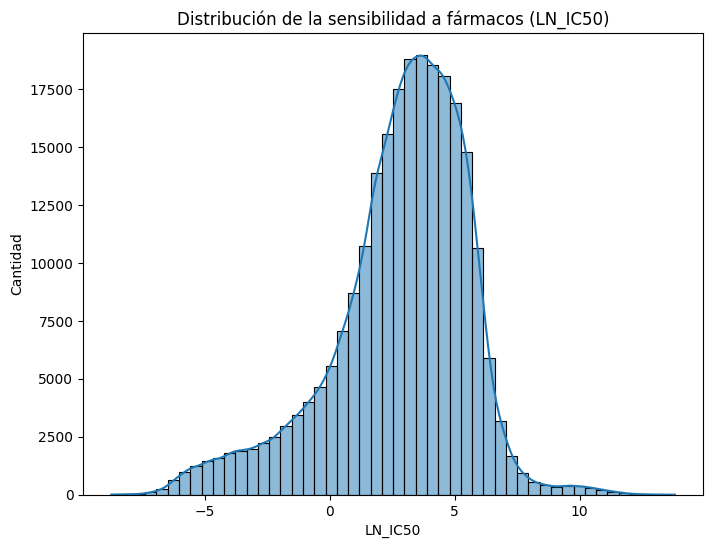

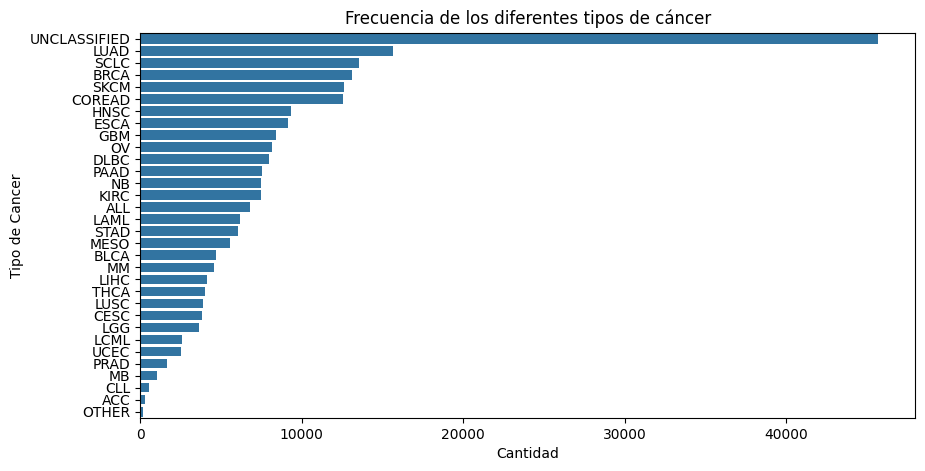

In [ ]:
# Histograma de la variable objetivo
plt.figure(figsize=(8, 6))
sns.histplot(data["LN_IC50"], bins=50, kde=True)
plt.title("Distribución de la sensibilidad a fármacos (LN_IC50)")
plt.ylabel("Cantidad")
plt.show()
print('\n')
# Contar la frecuencia de tipos de cáncer
plt.figure(figsize=(10, 5))
sns.countplot(y=data["TCGA_DESC"], order=data["TCGA_DESC"].value_counts().index)
plt.title("Frecuencia de los diferentes tipos de cáncer")
plt.ylabel('Tipo de Cancer')
plt.xlabel('Cantidad')
plt.show()


#### Como pudimos observar, la mayor cantidad del tipo de cáncer es la característica "no clasificado". Así mismos, la distribución por cantidad de la sensibilidad a los fármacos forma una campana con una leve inclinación hacia la derecha.

### Preprocesamiento de Datos.
 Como los datos de las columnas en su gran mayoría son categóricas. Las codificamos como números con LabelEncoder para luego fijarnos su impacto en el modelo.
 Para imputar los valores faltantes se creo la categoría 'Desconocido' antes de ser codificada cada columna.     

In [ ]:
encoder = LabelEncoder()
df_text = data.select_dtypes(include=['object'])
for col in df_text.columns:
  data[col] = data[col].fillna('Desconocido')
  data[f'{col}_encoder'] = encoder.fit_transform(data[col])

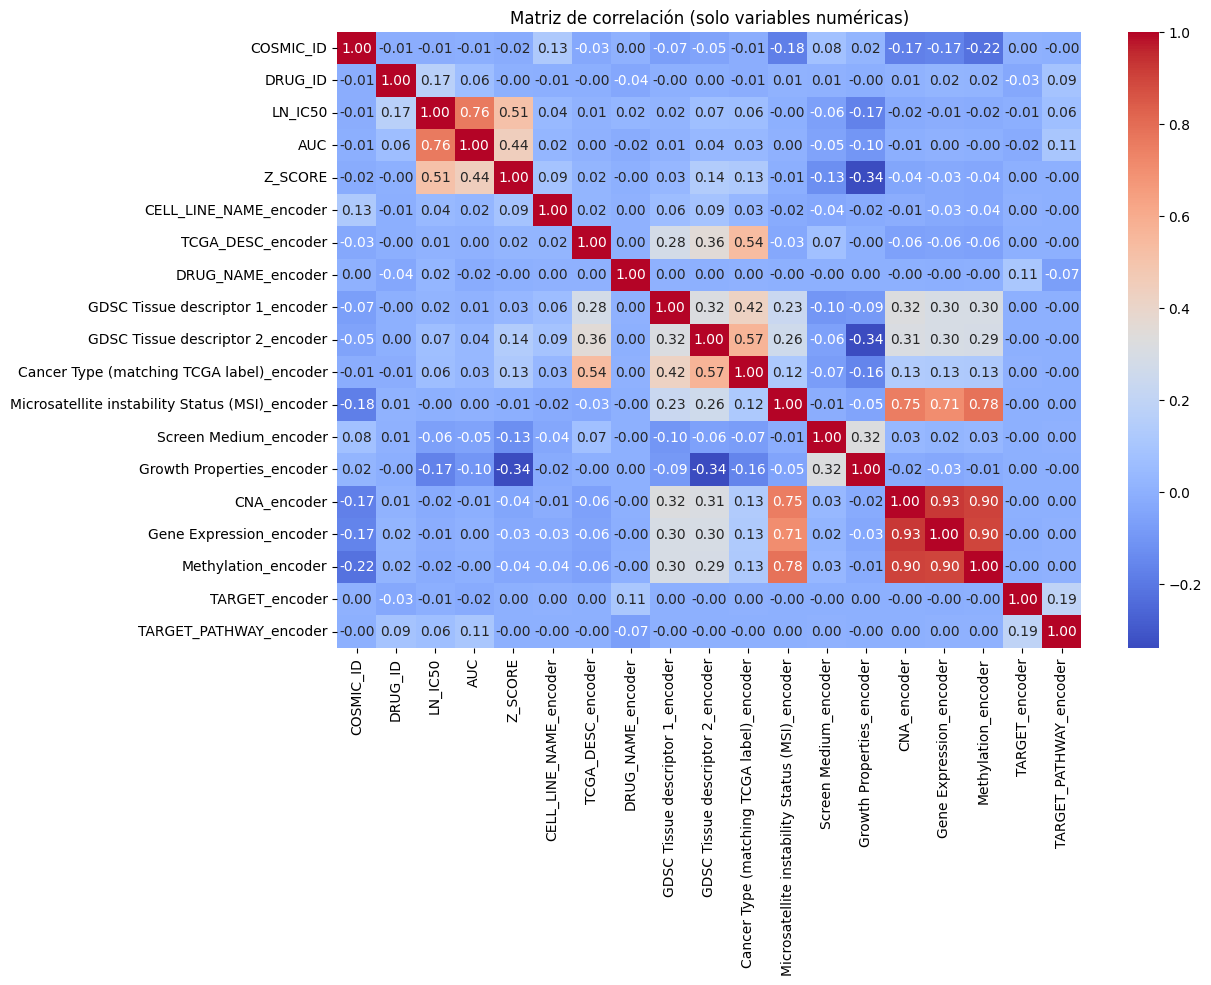

In [ ]:
# Celda de referencia. Solo se ejecutó la primera vez.
# Correlacion de todas las variables categoricas
# codificadas a int.

# Seleccionar solo columnas numéricas para la correlación
numeric_data = data.select_dtypes(include=['number'])

# Calcular la matriz de correlación
correlation_matrix = numeric_data.corr()

# Graficar la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación (solo variables numéricas)")
plt.show()



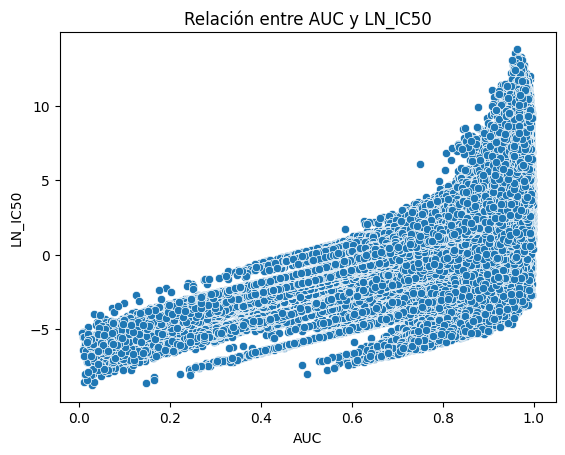

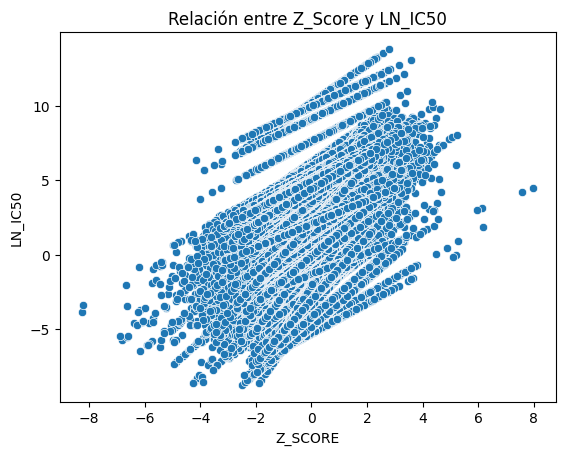

In [ ]:
# Relación entre LN_IC50 y AUC
sns.scatterplot(x=data['AUC'], y=data['LN_IC50'])
plt.title('Relación entre AUC y LN_IC50')
plt.show()
print('\n')
# Relación entre LN_IC50 y Z_Score
sns.scatterplot(x=data['Z_SCORE'], y=data['LN_IC50'])
plt.title('Relación entre Z_Score y LN_IC50')
plt.show()


### Selección de características y División del conjunto de datos
Uso selectKbest para encontrar los mejores predictores para 'LN_IC50'.
Como RandomForest no es sensible a la escala de las variables, no realizo ninguna escalamiento de variables y procedo directamente a la división del conjunto en entrenamiento y prueba.
Para este caso usamos 80% para entrenamiento y 20% del dataset para validación

In [ ]:
# Seleccionar las mejores características según su relación con LN_IC50
np.random.seed(42)
selector = SelectKBest(score_func=f_regression, k=5)
X_selected = selector.fit_transform(numeric_data.drop(columns=['LN_IC50', 'DRUG_ID']), numeric_data['LN_IC50'])

# Ver las características seleccionadas
selected_features = numeric_data.drop(columns=['LN_IC50', 'DRUG_ID']).columns[selector.get_support()].tolist()
print("Características seleccionadas:", selected_features)

Características seleccionadas: ['AUC', 'Z_SCORE', 'GDSC Tissue descriptor 2_encoder', 'Growth Properties_encoder', 'TARGET_PATHWAY_encoder']


In [ ]:
# Anteriormente probe sin 'Growth Properties_encoder' pero aunque su aporte es mínimo
# ayuda a un mejor rendimiento del modelo.
# Selecciono de esta manera porque kbest=4 elije 'Growth Properties_encoder' como características
# pero según  features_importances 'TARGET_PATHWAY_encoder' explica mejor LN_IC50
#X =  data[['AUC', 'Z_SCORE', 'GDSC Tissue descriptor 2_encoder', 'TARGET_PATHWAY_encoder']]

# Selección de variables relevantes
X = data[selected_features]
y = data['LN_IC50']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X.iloc[:5, :])


        AUC   Z_SCORE  GDSC Tissue descriptor 2_encoder  \
0  0.930220  0.433123                                37   
1  0.791072 -0.599569                                18   
2  0.592660 -1.516647                                18   
3  0.734047 -0.807232                                18   
4  0.582439 -1.570016                                18   

   Growth Properties_encoder  TARGET_PATHWAY_encoder  
0                          0                       7  
1                          0                       7  
2                          0                       7  
3                          0                       7  
4                          2                       7  


### Realizamos validación cruzada con 10 folds para RamdomForest.

In [ ]:
rf_model = RandomForestRegressor(
    n_estimators=200, # Número de estimadores.
    random_state=42 # semilla aleatoria.
)
scores = cross_val_score(rf_model, X_train, y_train, cv=10)
# Mostrar las puntuaciones obtenidas en cada pliegue
print("Puntuaciones de la validación cruzada:", scores)

# Mostrar la media de las puntuaciones
print("Media de las puntuaciones:", scores.mean())

Puntuaciones de la validación cruzada: [0.7632873  0.76155482 0.75965829 0.76228682 0.75724163 0.76035073
 0.7600095  0.76371489 0.76582715 0.7551124 ]
Media de las puntuaciones: 0.7609043541817954


### Buscamos los mejores hiperparámetros para el entrenamiento del modelo.
Anteriormente se busco con n_estimators: [50, 100, 150, 200]

In [ ]:
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
rf_model.set_params(**grid_search.best_params_)
# Ver los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)
# Evaluar con los mejores hiperparámetros
best_rf_model = grid_search.best_estimator_
y_pred_rf_best = best_rf_model.predict(X_test)
print(f"RMSE: {mean_squared_error(y_test, y_pred_rf_best,):.4f}")
print(f"R2 Score: {r2_score(y_test, y_pred_rf_best):.4f}")

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejores hiperparámetros: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 500}
RMSE: 1.6713
R2 Score: 0.7809


### Entrenando el modelo con los mejores hiperparámetros encontrados.

In [ ]:
# Entreno el modelo con los hiperparámetros
# optimizados mediante la búsqueda de cuadrícula.
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print(f"RMSE RandomForest: {mean_squared_error(y_test, y_pred_rf):.4f}")
print(f"R2 Score RandomForest: {r2_score(y_test, y_pred_rf):.4f}")

RMSE RandomForest: 1.6713
R2 Score RandomForest: 0.7809


### Visualizando la importacia relativa de las características en el modelo

In [ ]:
# Obtener la importancia de las características
importances = rf_model.feature_importances_

# Mostrar la importancia de cada característica
for feature, importance in zip(X.columns, importances):
    print(f"{feature}: {importance}")


AUC: 0.7800235390259287
Z_SCORE: 0.09548657579361777
GDSC Tissue descriptor 2_encoder: 0.012911997462385536
Growth Properties_encoder: 0.008338809237967308
TARGET_PATHWAY_encoder: 0.10323907848010065


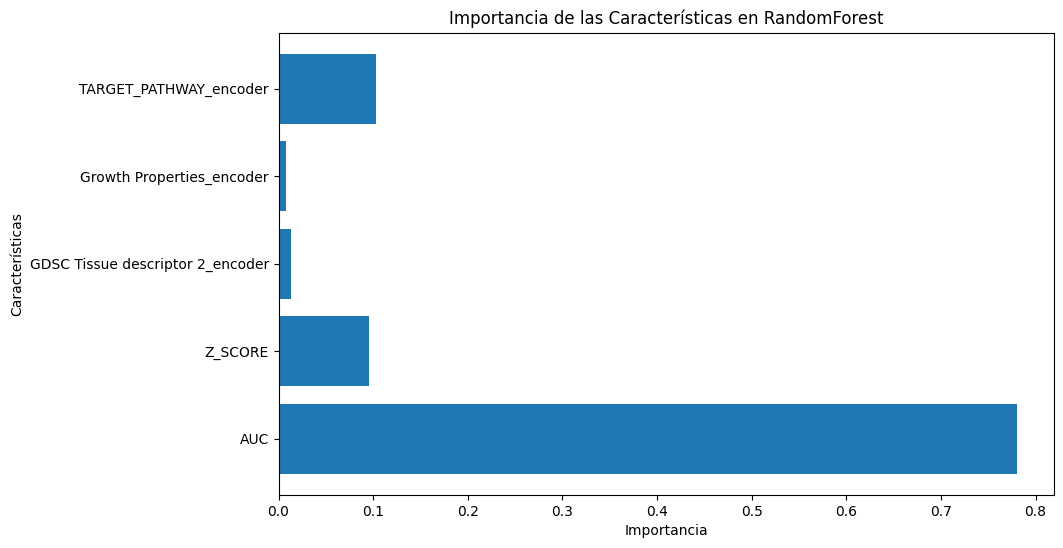

In [ ]:
# Crear un gráfico de barras para visualizar la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(X.columns, importances)
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de las Características en RandomForest')
plt.show()

### Gráfica para ver las predicciones correctas vs incorrectas del modelo.

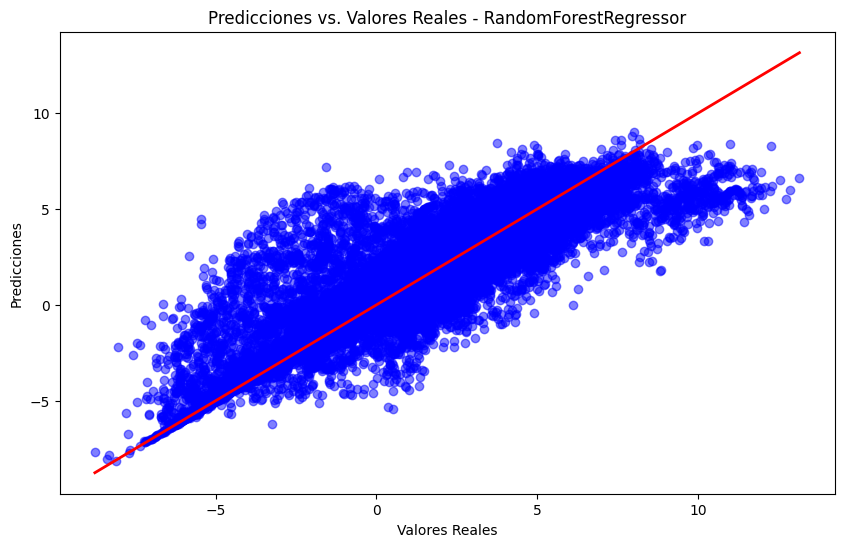

In [ ]:
# Graficar las predicciones vs los valores reales
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rf, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.title('Predicciones vs. Valores Reales - RandomForestRegressor')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()

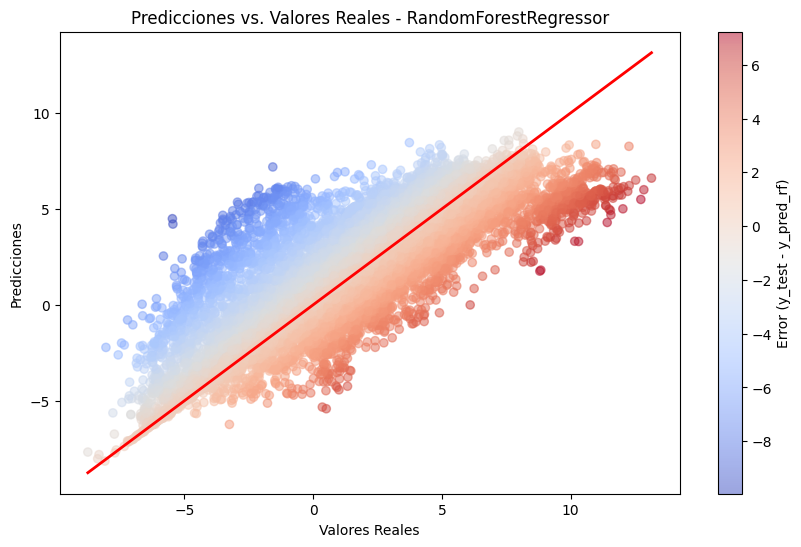

In [ ]:
# Calcular los errores
errors_rf = y_test - y_pred_rf

# Graficar las predicciones vs los valores reales
plt.figure(figsize=(10,6))

# Utilizar un mapa de colores para diferenciar los puntos (en este caso el error)
plt.scatter(y_test, y_pred_rf, c=errors_rf, cmap='coolwarm', alpha=0.5)

# Dibujar la línea de 1:1 (roja)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)

plt.title('Predicciones vs. Valores Reales - RandomForestRegressor')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')

# Agregar barra de color para mostrar el rango de errores
plt.colorbar(label='Error (y_test - y_pred_rf)')

plt.show()


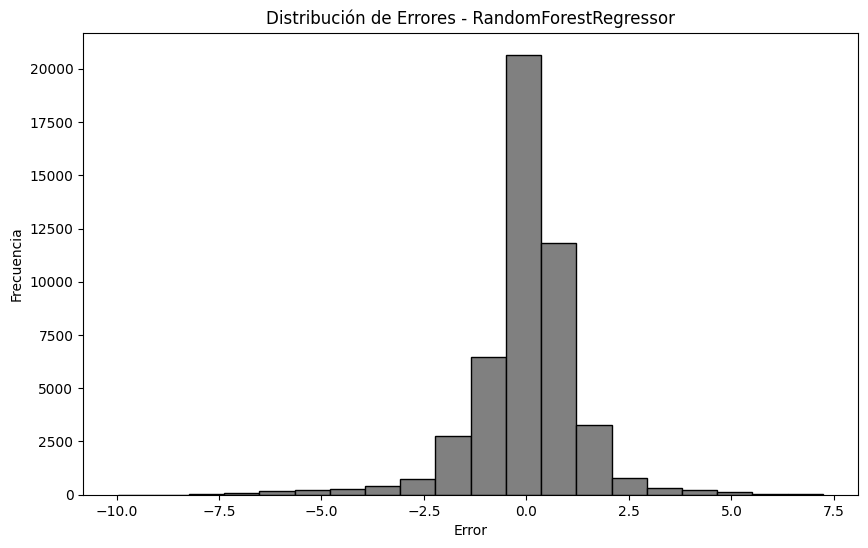

In [ ]:
# Calcular los errores
errors_rf = y_test - y_pred_rf

# Graficar la distribución de los errores
plt.figure(figsize=(10,6))
plt.hist(errors_rf, bins=20, color='gray', edgecolor='black')
plt.title('Distribución de Errores - RandomForestRegressor')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.show()


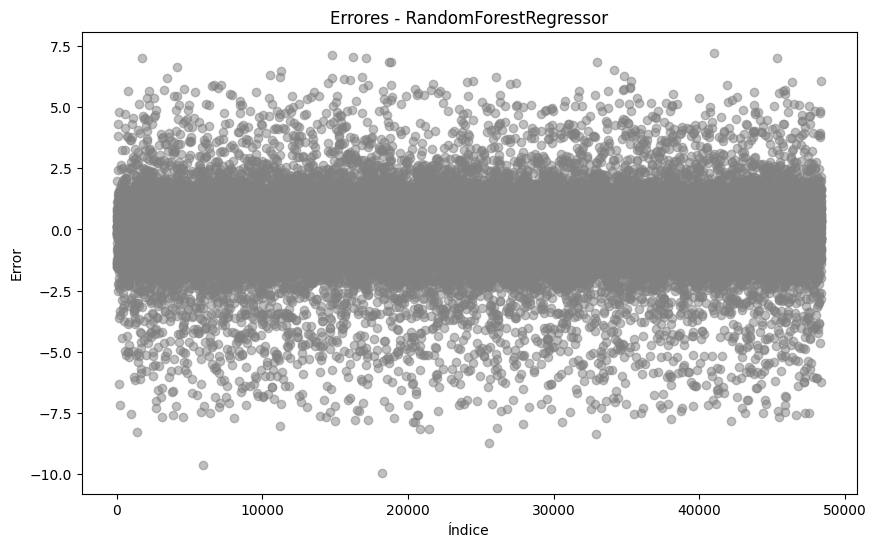

In [ ]:
# Graficar errores en un gráfico de dispersión
plt.figure(figsize=(10,6))
plt.scatter(range(len(errors_rf)), errors_rf, color='gray', alpha=0.5)
plt.title('Errores - RandomForestRegressor')
plt.xlabel('Índice')
plt.ylabel('Error')
plt.show()


### Conclusión:
RandomForestClassifier resulto ser un buen modelo para la predicción de la sensiblidad de fármacos de las células cancerozas. Siendo AUC la varibale que más explica LN_IC50 con casí un 80%.
Como resultado final obtenemos un modelo que explica el 78,09% del dataset siendo este un buen resultado aunque aún se le pueden buscar mejoras.

## Comparando el desempeño de los Árboles de Decisión para esta misma tarea.
Ahora que ya hemos comprobado el desempeño de los bosques aleatorios, procedemos a realizar las mismas acciones para los Árboles de Decisión para comparar ambos modelos.

In [ ]:
# Definimos el modelo
model_tree = DecisionTreeRegressor(n_estimators=200, random_state=42)

### Comprobamos el posible rendimiento con validación cruzada de 10 folds.

In [ ]:
scores = cross_val_score(model_tree, X_train, y_train, cv=10)
# Mostrar las puntuaciones obtenidas
print("Puntuación de la validación cruzado", scores)
# mostrar la media de las puntuaciones
print("Puntuación promedio para DecisionTree: ", scores.mean())